In [1]:
# copyright: https://github.com/konosp/propensity-score-matching/blob/main/propensity_score_matching_v2.ipynb
# for personal study purposes only

- X: features (age, fare)
- T: treatment (hasCabin)
- y: survived indicator

- Want to see whether hasCabin affects survival probability
- But treatment assignment is not random, potentially determined by X, which also affects y

- Basically
    - survived = hasCabin + $\epsilon$
    - $\epsilon$ = $\epsilon$(X) is correlated with hasCabin
$$

In [2]:
import math
import numpy as np
import pandas as pd
# import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics


In [4]:
import math
import pandas as pd

def perform_match_exact(row, df , *args):
    # row is the the item that we want to match
    # df is the source Pandas dataframe that we want to match it with other items
    # print('Start matching')
    sub_set = df
    
    for arg in args:
        sub_set = sub_set.loc[sub_set[arg] == row[arg]]
        # print(sub_set)
        
    return sub_set.index


def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

def hasCabin(x):
    if pd.isna(x):
        return 0
    else:
        return 1
    
def cohenD (tmp, metricName):
    treated_metric = tmp[tmp.treatment == 1][metricName]
    untreated_metric = tmp[tmp.treatment == 0][metricName]
    
    d = ( treated_metric.mean() - untreated_metric.mean() ) / math.sqrt(((treated_metric.count()-1)*treated_metric.std()**2 + (untreated_metric.count()-1)*untreated_metric.std()**2) / (treated_metric.count() + untreated_metric.count()-2))
    return d

In [8]:
df = pd.read_csv('train.csv')

df = df[~df.Age.isna()]
df = df[~df.Embarked.isna()]
df = df.reset_index()
y = df[['Survived']]
df = df.drop(columns = ['Survived'])

df['treatment'] = df.Cabin.apply(hasCabin)


df = df[['treatment','Sex','Age','SibSp','Parch','Embarked', 'Pclass', 'Fare']]


In [9]:
df.head()

,treatment,Sex,Age,SibSp,Parch,Embarked,Pclass,Fare
0,0,male,22.0,1,0,S,3,7.2500
1,1,female,38.0,1,0,C,1,71.2833
2,0,female,26.0,0,0,S,3,7.9250
3,1,female,35.0,1,0,S,1,53.1000
4,0,male,35.0,0,0,S,3,8.0500


0.9283707865168539
[[503  26]
 [ 25 158]]
0.8610354223433242


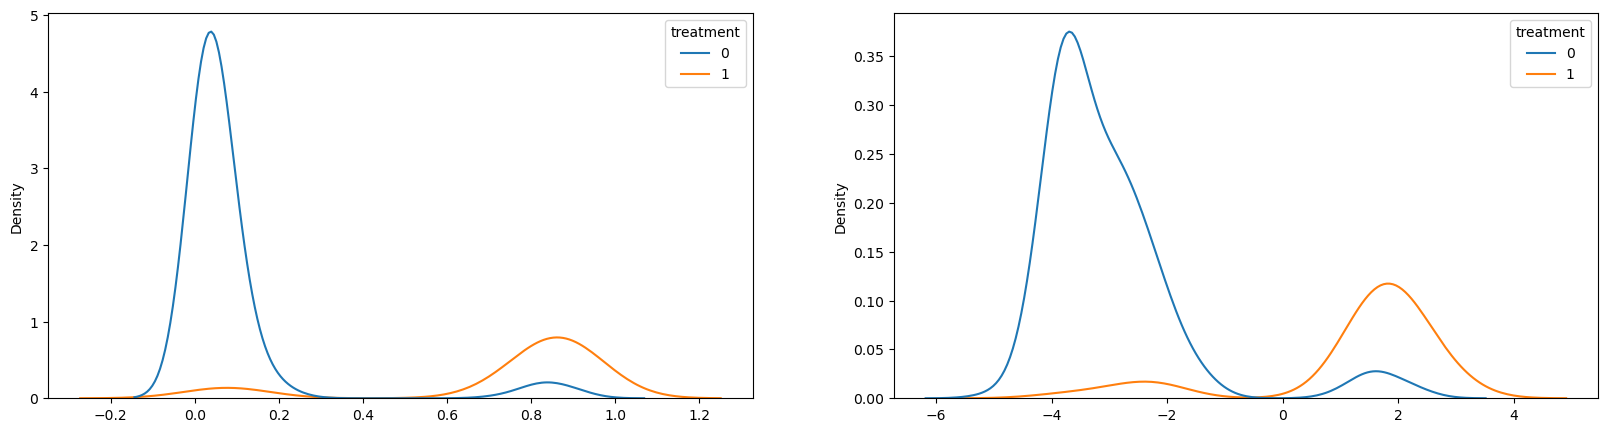

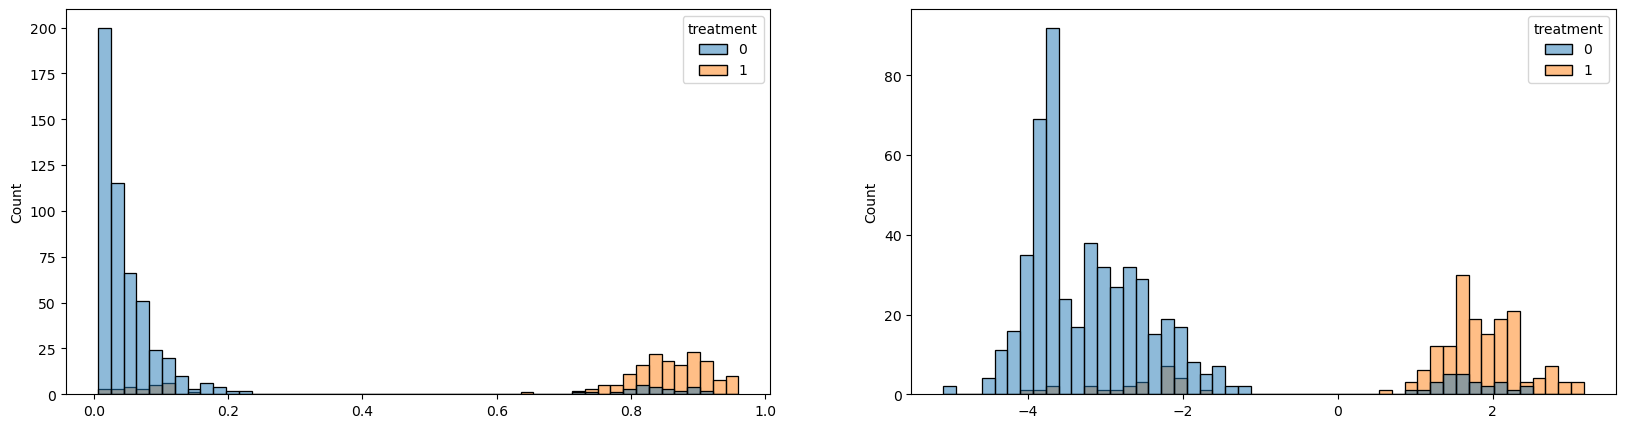

In [20]:
T = df['treatment']
X = df.drop('treatment', axis = 1)
X_encoded = pd.get_dummies(
    X,
    columns = ['Sex','Embarked', 'Pclass'], 
    prefix = {'Sex':'sex', 'Embarked' : 'embarked', 'Pclass' : 'class'}, 
    drop_first=False,
)




# propensity estimate
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('logistic_regression', lr()),
    ]
)
pipe.fit(X_encoded, T)

predictions = pipe.predict_proba(X_encoded)
predictions_binary = pipe.predict(X_encoded)
predictions_logit = np.array([logit(x) for x in predictions[:, 1]])


X_encoded['propensity_score'] = predictions[:,1]
X_encoded['propensity_score_logit'] = predictions_logit
X_encoded['outcome'] = y.Survived
X_encoded['treatment'] = df['treatment']




# how well is propensity estimate
print(metrics.accuracy_score(T, predictions_binary))
print(metrics.confusion_matrix(T, predictions_binary))
print(metrics.f1_score(T, predictions_binary))

fig, ax = plt.subplots(1, 2, figsize = (20, 5))
sns.kdeplot(x = predictions[:, 1], hue = T, ax = ax[0])
sns.kdeplot(x = predictions_logit, hue = T, ax = ax[1])
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (20, 5))
sns.histplot(x = predictions[:, 1], hue = T, bins = 50, ax = ax[0])
sns.histplot(x = predictions_logit, hue = T, bins = 50, ax = ax[1])
plt.show()

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_regression', LogisticRegression())])

In [21]:
X_encoded.head()

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,0.021156,-3.834463,0,0
1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0,0.866755,1.872566,1,1
2,26.0,0,0,7.9250,1,0,0,0,1,0,0,1,0.039982,-3.178512,1,0
3,35.0,1,0,53.1000,1,0,0,0,1,1,0,0,0.895107,2.144005,1,1
4,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,0.019913,-3.896294,0,0


## Matching

In [24]:
caliper = np.std(
    X_encoded['propensity_score']
) * 0.25

print(f'caliper = {caliper}')


knn = NearestNeighbors(
    n_neighbors=10,
    p=2,
    radius = caliper,
)
knn.fit(
    X_encoded[['propensity_score_logit']]
)


distances, indexes = knn.kneighbors(
    X_encoded[['propensity_score_logit']],
    n_neighbors=10,
)



caliper = 0.08890268148266277


In [48]:
def perform_matching_v2(row, indexes, X_encoded):
    current_index = int(row['index'])
    for idx in indexes[current_index,:]:
        if current_index != idx and (row['treatment'] == 1) and X_encoded.loc[idx]['treatment'] == 0:
            return int(idx)

X_encoded['matched_element'] = X_encoded.reset_index().apply(perform_matching_v2, axis = 1, args = (indexes, X_encoded))

In [46]:
indexes[0], indexes_subset[0]

(array([  0, 607, 539, 301, 590, 641, 611,  36, 134, 449]),
 [607, 539, 301, 590, 641, 611, 36, 134, 449])

In [ ]:
treated = X_encoded.query('treatment == 1') # only keep T = 1


treated['matched_element'] = treated.apply('') # find a match where T = 0, not itself, and closest

In [50]:
def perfom_matching_v2(row, indexes, df_data):
    current_index = int(row['index']) # Obtain value from index-named column, not the actual DF index.
    prop_score_logit = row['propensity_score_logit']
    for idx in indexes[current_index,:]:
        if (current_index != idx) and (row.treatment == 1) and (df_data.loc[idx].treatment == 0):
            return int(idx)
         
X_encoded['matched_element'] = X_encoded.reset_index().apply(perfom_matching_v2, axis = 1, args = (indexes, X_encoded))

treated_with_match = ~X_encoded.matched_element.isna()
treated_matched_data = X_encoded[treated_with_match]

In [51]:
treated_matched_data

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment,matched_element
1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0,0.866755,1.872566,1,1,62.0
3,35.0,1,0,53.1000,1,0,0,0,1,1,0,0,0.895107,2.144005,1,1,306.0
5,54.0,0,0,51.8625,0,1,0,0,1,1,0,0,0.805110,1.418544,0,1,372.0
9,4.0,1,1,16.7000,1,0,0,0,1,0,0,1,0.063216,-2.695902,1,1,686.0
10,58.0,0,0,26.5500,1,0,0,0,1,1,0,0,0.875412,1.949679,1,1,478.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,48.0,0,0,25.9292,1,0,0,0,1,1,0,0,0.892931,2.121035,1,1,425.0
691,31.0,0,0,50.4958,0,1,0,0,1,1,0,0,0.859673,1.812578,0,1,358.0
694,47.0,1,1,52.5542,1,0,0,0,1,1,0,0,0.902103,2.220808,1,1,670.0
695,33.0,0,0,5.0000,0,1,0,0,1,1,0,0,0.863148,1.841688,0,1,62.0


In [54]:
untreated_matched_data = pd.DataFrame(
    data = treated_matched_data['matched_element']
)
attributes = ['Age', 'SibSp', 'Parch', 'Fare', 'sex_female', 'sex_male', 'embarked_C',
       'embarked_Q', 'embarked_S', 'class_1', 'class_2', 'class_3',
       'propensity_score', 'propensity_score_logit', 'outcome', 'treatment']

def obtain_match_details(row, all_data, attribute):
    return all_data.loc[row['matched_element']][attribute]
for attr in attributes:
    untreated_matched_data[attr] = untreated_matched_data.apply(obtain_match_details, axis = 1, all_data = X_encoded, attribute = attr)


untreated_matched_data


,matched_element,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment
1,62.0,28.0,0.0,0.0,47.100,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.866278,1.868444,0.0,0.0
3,306.0,35.0,1.0,0.0,52.000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.895251,2.145533,1.0,0.0
5,372.0,56.0,0.0,0.0,26.550,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.805278,1.419613,0.0,0.0
9,686.0,21.0,1.0,0.0,11.500,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.063344,-2.693730,0.0,0.0
10,478.0,27.0,0.0,0.0,30.500,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.870857,1.908556,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,425.0,30.0,0.0,0.0,106.425,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.892933,2.121059,1.0,0.0
691,358.0,34.0,0.0,0.0,26.550,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.857502,1.794699,1.0,0.0
694,670.0,30.0,0.0,0.0,31.000,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.902547,2.225850,1.0,0.0
695,62.0,28.0,0.0,0.0,47.100,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.866278,1.868444,0.0,0.0


In [56]:
X_encoded['treatment'].value_counts()

0    529
1    183
Name: treatment, dtype: int64

In [57]:
all_matched_data = pd.concat([treated_matched_data, untreated_matched_data], axis = 0)

[(-6.0, 6.0)]

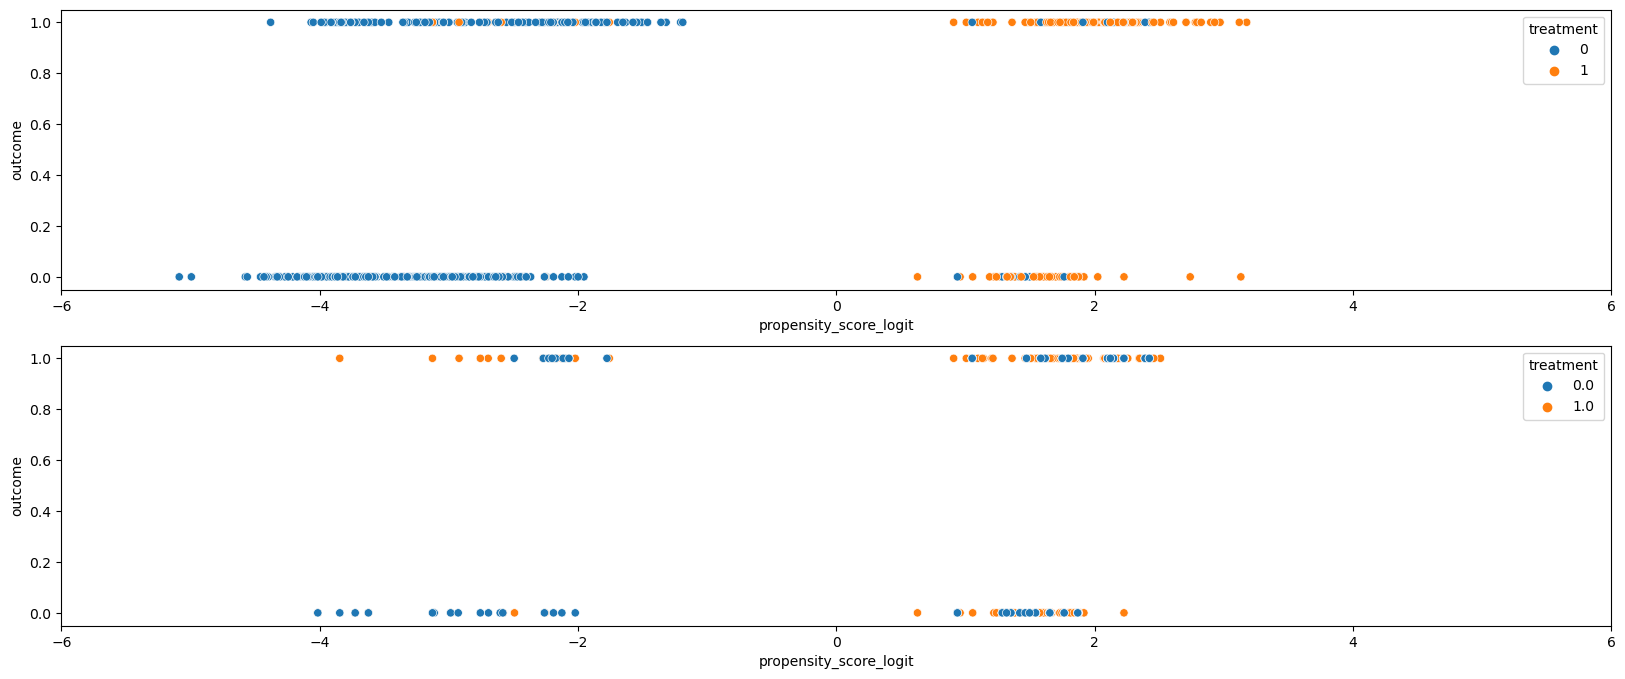

In [68]:
fig, ax = plt.subplots(2, 1, figsize = (20, 8))
sns.scatterplot(data = X_encoded, y = 'outcome', x = 'propensity_score_logit', hue = 'treatment', ax = ax[0],).set(xlim = (-6, 6))
sns.scatterplot(data = all_matched_data, y = 'outcome', x = 'propensity_score_logit', hue = 'treatment', ax = ax[1],).set(xlim = (-6, 6))